# Chapter 8 - Tree-based Methods

In [1]:
# %load ../standard_import.txt
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

import pydot
from IPython.display import Image

from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn.externals.six import StringIO  
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import confusion_matrix, classification_report, mean_squared_error

pd.set_option('display.notebook_repr_html', False)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 150)
pd.set_option('display.max_seq_items', None)
 
#%config InlineBackend.figure_formats = {'pdf',}
%matplotlib inline

import seaborn as sns
sns.set_context('notebook')
sns.set_style('white')

In [8]:
# This function creates images of tree models using pydot
def print_tree(estimator, features, class_names=None, filled=True):
    tree = estimator
    names = features
    color = filled
    classn = class_names
    
    dot_data = StringIO()
    export_graphviz(estimator, out_file=dot_data, feature_names=features, class_names=classn, filled=filled)
    graph = pydot.graph_from_dot_data(dot_data.getvalue())
    return(graph)

### § 8.1.1 Regression Trees

In [3]:
df = pd.read_csv('Data/Hitters.csv').dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 263 entries, 1 to 321
Data columns (total 21 columns):
Unnamed: 0    263 non-null object
AtBat         263 non-null int64
Hits          263 non-null int64
HmRun         263 non-null int64
Runs          263 non-null int64
RBI           263 non-null int64
Walks         263 non-null int64
Years         263 non-null int64
CAtBat        263 non-null int64
CHits         263 non-null int64
CHmRun        263 non-null int64
CRuns         263 non-null int64
CRBI          263 non-null int64
CWalks        263 non-null int64
League        263 non-null object
Division      263 non-null object
PutOuts       263 non-null int64
Assists       263 non-null int64
Errors        263 non-null int64
Salary        263 non-null float64
NewLeague     263 non-null object
dtypes: float64(1), int64(16), object(4)
memory usage: 41.1+ KB


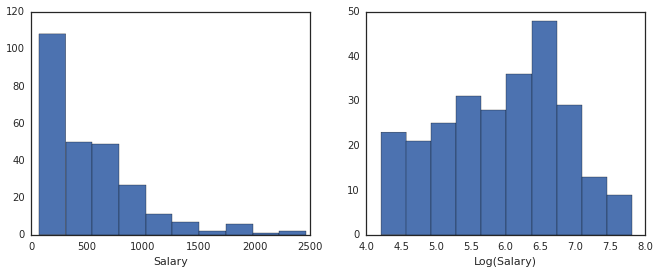

In [4]:
X = df[['Years', 'Hits']].as_matrix()
y = np.log(df.Salary.as_matrix())

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(11,4))
ax1.hist(df.Salary.as_matrix())
ax1.set_xlabel('Salary')
ax2.hist(y)
ax2.set_xlabel('Log(Salary)')

In [9]:
regr = DecisionTreeRegressor(max_leaf_nodes=3)
regr.fit(X, y)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=3, min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, random_state=None,
           splitter='best')

### Figure 8.1

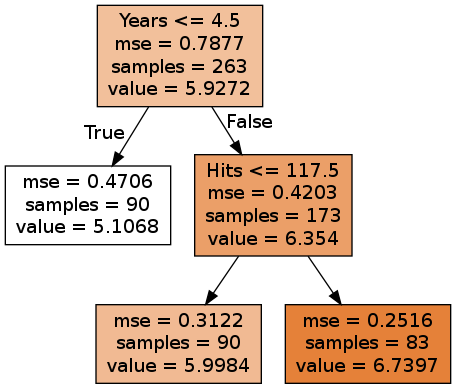

In [10]:
graph = print_tree(regr, features=['Years', 'Hits'])
Image(graph.create_png())

###  Figure 8.2

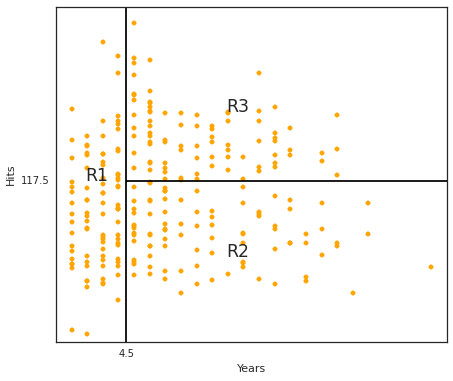

In [11]:
df.plot('Years', 'Hits', kind='scatter', color='orange', figsize=(7,6))
plt.xlim(0,25)
plt.ylim(ymin=-5)
plt.xticks([4.5])
plt.yticks([117.5])
plt.vlines(4.5, ymin=-5, ymax=250)
plt.hlines(117.5, xmin=4.5, xmax=25)
plt.annotate('R1', xy=(2,117.5), fontsize='xx-large')
plt.annotate('R2', xy=(11,60), fontsize='xx-large')
plt.annotate('R3', xy=(11,170), fontsize='xx-large')

### Pruning
This is currently not supported in scikit-learn. See first point under 'disadvantages of decision trees in the <A href='http://scikit-learn.github.io/dev/modules/tree.html#'>documentation</A>. Implementation has been <A href='https://github.com/scikit-learn/scikit-learn/pull/941'>discussed</A> but Random Forests have better predictive qualities than a single pruned tree anyway if I understand correctly.
    

### § 8.1.2 Classification Trees

In [12]:
df2 = pd.read_csv('Data/Heart.csv').drop('Unnamed: 0', axis=1).dropna()
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 297 entries, 0 to 301
Data columns (total 14 columns):
Age          297 non-null int64
Sex          297 non-null int64
ChestPain    297 non-null object
RestBP       297 non-null int64
Chol         297 non-null int64
Fbs          297 non-null int64
RestECG      297 non-null int64
MaxHR        297 non-null int64
ExAng        297 non-null int64
Oldpeak      297 non-null float64
Slope        297 non-null int64
Ca           297 non-null float64
Thal         297 non-null object
AHD          297 non-null object
dtypes: float64(2), int64(9), object(3)
memory usage: 31.3+ KB


In [13]:
df2.ChestPain = pd.factorize(df2.ChestPain)[0]
df2.Thal = pd.factorize(df2.Thal)[0]

In [14]:
X2 = df2.drop('AHD', axis=1)
y2 = pd.factorize(df2.AHD)[0]

In [18]:
clf = DecisionTreeClassifier(max_depth=None, max_leaf_nodes=6, max_features=3)
clf.fit(X2,y2)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=3, max_leaf_nodes=6, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            random_state=None, splitter='best')

In [19]:
clf.score(X2,y2)

0.84175084175084181

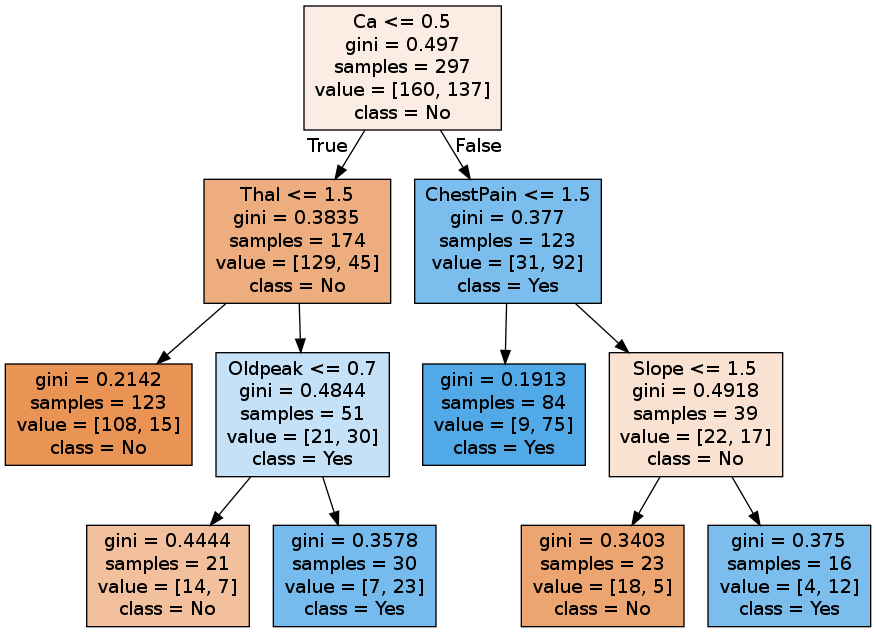

In [20]:
graph2 = print_tree(clf, features=X2.columns, class_names=['No', 'Yes'])
Image(graph2.create_png())

## Lab

### § 8.3.1 Fitting Classification Trees

In [31]:
# In R, I exported the dataset from package 'ISLR' to a csv file.
df3 = pd.read_csv('Data/Carseats.csv').drop('Unnamed: 0', axis=1)
df3.head()

   Sales  CompPrice  Income  Advertising  Population  Price ShelveLoc  Age  \
0   9.50        138      73           11         276    120       Bad   42   
1  11.22        111      48           16         260     83      Good   65   
2  10.06        113      35           10         269     80    Medium   59   
3   7.40        117     100            4         466     97    Medium   55   
4   4.15        141      64            3         340    128       Bad   38   

   Education Urban   US  
0         17   Yes  Yes  
1         10   Yes  Yes  
2         12   Yes  Yes  
3         14   Yes  Yes  
4         13   Yes   No  

In [32]:
df3['High'] = df3.Sales.map(lambda x: 1 if x>8 else 0)
df3.ShelveLoc = pd.factorize(df3.ShelveLoc)[0]

df3.Urban = df3.Urban.map({'No':0, 'Yes':1})
df3.US = df3.US.map({'No':0, 'Yes':1})
df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 400 entries, 0 to 399
Data columns (total 12 columns):
Sales          400 non-null float64
CompPrice      400 non-null int64
Income         400 non-null int64
Advertising    400 non-null int64
Population     400 non-null int64
Price          400 non-null int64
ShelveLoc      400 non-null int32
Age            400 non-null int64
Education      400 non-null int64
Urban          400 non-null int64
US             400 non-null int64
High           400 non-null int64
dtypes: float64(1), int32(1), int64(10)
memory usage: 39.1 KB


In [33]:
df3.head(5)

   Sales  CompPrice  Income  Advertising  Population  Price  ShelveLoc  Age  \
0   9.50        138      73           11         276    120          0   42   
1  11.22        111      48           16         260     83          1   65   
2  10.06        113      35           10         269     80          2   59   
3   7.40        117     100            4         466     97          2   55   
4   4.15        141      64            3         340    128          0   38   

   Education  Urban  US  High  
0         17      1   1     1  
1         10      1   1     1  
2         12      1   1     1  
3         14      1   1     0  
4         13      1   0     0  

In [55]:
X = df3.drop(['Sales', 'High'], axis=1)
y = df3.High

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.5, random_state=0)

In [46]:
clf = DecisionTreeClassifier(max_depth=6)
clf.fit(X, y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=6,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            random_state=None, splitter='best')

In [47]:
print(classification_report(y, clf.predict(X)))

             precision    recall  f1-score   support

          0       0.89      0.99      0.93       236
          1       0.98      0.82      0.89       164

avg / total       0.92      0.92      0.92       400



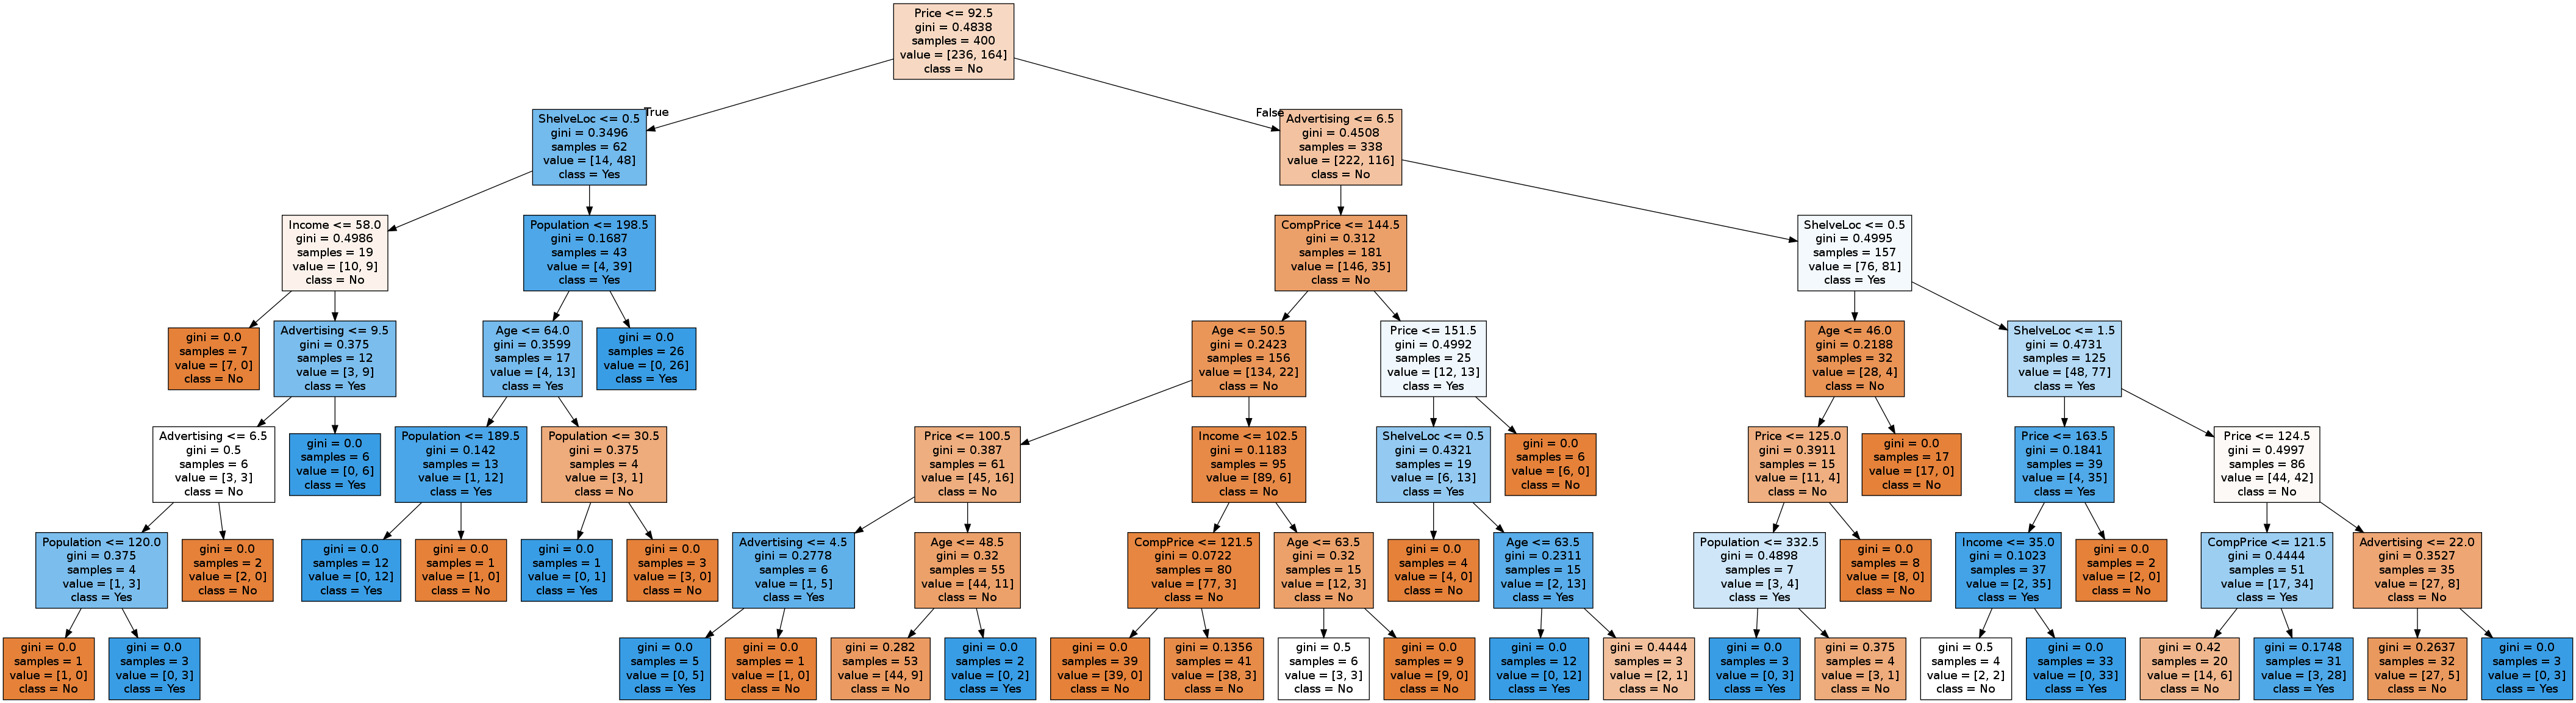

In [48]:
graph3 = print_tree(clf, features=X.columns, class_names=['No', 'Yes'])
Image(graph3.create_png())

In [56]:
clf.fit(X_train, y_train)
pred = clf.predict(X_test)

In [57]:
cm = pd.DataFrame(confusion_matrix(y_test, pred).T, index=['No', 'Yes'], columns=['No', 'Yes'])
cm.index.name = 'Predicted'
cm.columns.name = 'True'
cm

True       No  Yes
Predicted         
No         99   32
Yes        19   50

In [58]:
# Precision of the model using test data is 74%
print(classification_report(y_test, pred))

             precision    recall  f1-score   support

          0       0.76      0.84      0.80       118
          1       0.72      0.61      0.66        82

avg / total       0.74      0.74      0.74       200



Pruning not implemented in scikit-learn.

### § 8.3.2 Fitting Regression Trees

In [60]:
# In R, I exported the dataset from package 'MASS' to a csv file.
boston_df = pd.read_csv('Data/Boston.csv')
boston_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 506 entries, 0 to 505
Data columns (total 14 columns):
crim       506 non-null float64
zn         506 non-null float64
indus      506 non-null float64
chas       506 non-null int64
nox        506 non-null float64
rm         506 non-null float64
age        506 non-null float64
dis        506 non-null float64
rad        506 non-null int64
tax        506 non-null int64
ptratio    506 non-null float64
black      506 non-null float64
lstat      506 non-null float64
medv       506 non-null float64
dtypes: float64(11), int64(3)
memory usage: 59.3 KB


In [61]:
X = boston_df.drop('medv', axis=1)
y = boston_df.medv

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.5, random_state=0)

In [62]:
# Pruning not supported. Choosing max depth 3)
regr2 = DecisionTreeRegressor(max_depth=3)
regr2.fit(X_train, y_train)
pred = regr2.predict(X_test)

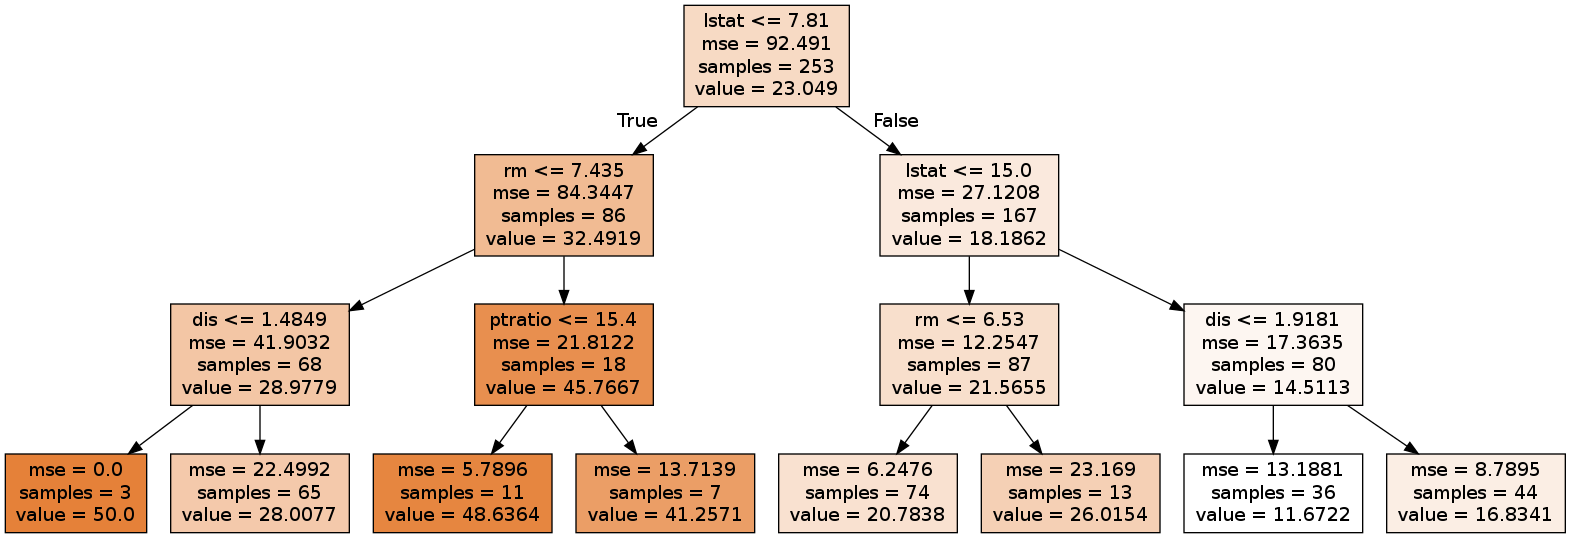

In [63]:
graph = print_tree(regr2, features=X.columns)
Image(graph.create_png())

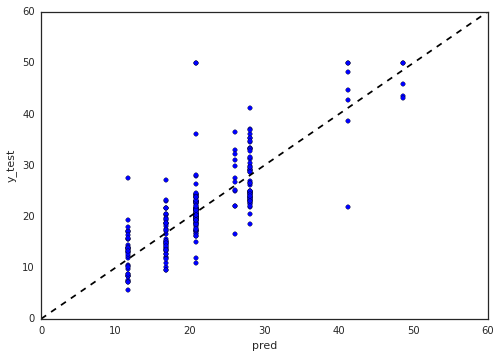

In [64]:
plt.scatter(pred, y_test, label='medv')
plt.plot([0, 1], [0, 1], '--k', transform=plt.gca().transAxes)
plt.xlabel('pred')
plt.ylabel('y_test')

In [65]:
mean_squared_error(y_test, pred)

26.023230850097448

### § 8.3.3 Bagging and Random Forests

In [66]:
# There are 13 features in the dataset
X.shape

(506, 13)

In [141]:
# Bagging: using all features
regr1 = RandomForestRegressor(max_features=13, random_state=1)
regr1.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=13, max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=1,
           verbose=0, warm_start=False)

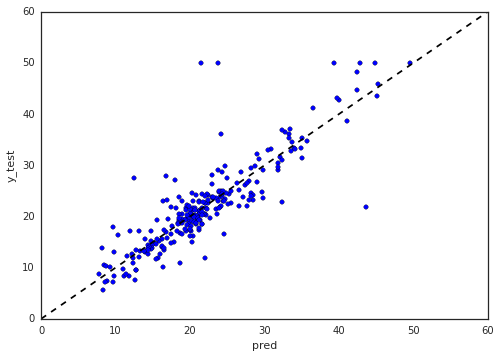

In [142]:
pred = regr1.predict(X_test)

plt.scatter(pred, y_test, label='medv')
plt.plot([0, 1], [0, 1], '--k', transform=plt.gca().transAxes)
plt.xlabel('pred')
plt.ylabel('y_test')

In [143]:
mean_squared_error(y_test, pred)

18.223911462450594

In [148]:
# Random forests: using 6 features
regr2 = RandomForestRegressor(max_features=6, random_state=1)
regr2.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=6, max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=1,
           verbose=0, warm_start=False)

In [149]:
pred = regr2.predict(X_test)
mean_squared_error(y_test, pred)

15.860589723320158

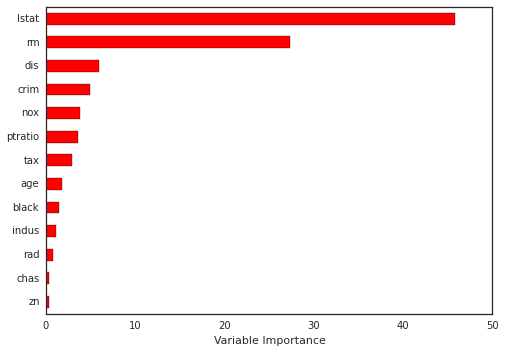

In [150]:
Importance = pd.DataFrame({'Importance':regr2.feature_importances_*100}, index=X.columns)
Importance.sort('Importance', axis=0, ascending=True).plot(kind='barh', color='r', )
plt.xlabel('Variable Importance')
plt.gca().legend_ = None

### § 8.3.4 Boosting

In [191]:
regr = GradientBoostingRegressor(n_estimators=500, learning_rate=0.01, random_state=1)
regr.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, init=None, learning_rate=0.01, loss='ls',
             max_depth=3, max_features=None, max_leaf_nodes=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=500,
             random_state=1, subsample=1.0, verbose=0, warm_start=False)

zn          0.170382
rad         1.662870
chas        1.851882
indus       3.037241
nox         3.219764
tax         5.045804
black       5.137142
age         5.654815
crim        6.797925
ptratio     8.123222
dis        10.178376
rm         22.133661
lstat      26.986916
dtype: float64


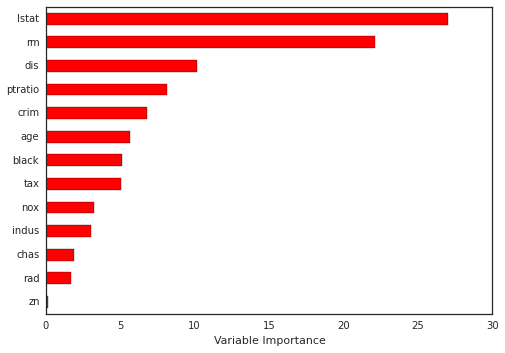

In [192]:
feature_importance = regr.feature_importances_*100
rel_imp = pd.Series(feature_importance, index=X.columns).sort(inplace=False)
print(rel_imp)
rel_imp.T.plot(kind='barh', color='r', )
plt.xlabel('Variable Importance')
plt.gca().legend_ = None

In [193]:
mean_squared_error(y_test, regr.predict(X_test))

15.545872251748079